# Sreyashi Saha
# Mat No: 1747271              
# Group 1            Assignment 7

Importing all the libraries required to implement LeNet architechture on MNIST data set.

In [1]:
import numpy as np
from datetime import datetime 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets, transforms

import matplotlib.pyplot as plt

import torch
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

# check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

Since CUDA is not installed on my device, I check if GPU is availabe and since it is not therefore, my program is trained on the CPU.

In [2]:
# pip install torch torchvision torchaudio

## LeNet Architechture On MNIST
The LeNet-5 CNN architecture has seven layers. Three convolutional layers, two subsampling layers, and two fully linked layers make up the layer composition. 

The input layer, which is the initial layer, is typically not thought of as part of the network because nothing is learned there. The following layer receives photos that are 32x32 in size since the input layer is designed to accept images of that size. The images in the MNIST collection are 28x28 sized images, which are padded to bring the MNIST images' dimensions into compliance with the input layer's specifications.

The pixel values of the grayscale images used in the study were normalized from 0 to 255 to values between -0.1 and 1.175. To ensure that the batch of images has a mean of 0 and a standard deviation of 1, normalization is used. The benefit of this is a decrease in training time. We'll be normalizing the pixel values of the photos to take on values between 0 and 1 for the image classification with LeNet-5.

The naming convention used by the authors to implement LeNet is as follows:

 - Cx — convolution layer,
 - Sx — subsampling (pooling) layer,
 - Fx — fully-connected layer,
 - x — index of the layer
 
The Formula used to get the output dimensions after each layer is:
#### (W−F+2P)/S+1 , 
where W is the input height/width, F is the filter/kernel size, P is the padding, and S is the stride.
        

Now let's scheme through the 7 layers to get a better understanding of the LeNet Architechture:

1) Layer1(C1): The first convolutional layer has six 5 * 5 kernels with a stride of 1. The window containing the weight values used during the convolution of the weight values with the input values is referred to as the kernel/filter. The local receptive field size of each unit or neuron within a convolutional layer is also represented by the number 5 * 5. The output of this layer is of size 28 * 28 * 6 given the input size (32 * 32 * 1).

2) Layer2(S1): A pooling/subsampling layer with a stride of 2 and six 2 * 2 kernels. Compared to the more conventional max/average pooling layers, the subsampling layer in the original architecture was a little more complicated. A unit in S2 has four inputs, which are added, multiplied by a trainable coefficient, multiplied by a trainable bias, and added. A sigmoidal or tanh or ReLU activation functions are applied to the outcome. The input to this layer is downsampled (14 * 14 * 6) due to non-overlapping receptive fields, which is also referred to as downsampling.

3) Layer3(C2): The second convolutional layer with the same configuration as the first one, but with 16 filters instead of 6. The output of this layer is 10 * 10 * 16.

4) Layer4(S2): The second pooling layer. The logic is identical to the previous one, but with 16 filters instead of 6. The output of this layer is of size 5 * 5 * 16.

5) Layer5(C5): 120 5 * 5 kernels are used in the final convolutional layer. Given that the kernels in this layer are 5 * 5 and the input is 5 * 5 * 16, the output is 1 * 1 * 120. Layers S4 and C5 are hence totally linked. This is also the reason why some LeNet-5 implementations actually utilize a fully-connected layer as the fifth layer rather than a convolutional one. This layer is kept as a convolutional one because if the network's input is larger than the one used in [1] (the starting input, which in MNIST case is 32 * 32), this layer won't be properly linked because each kernel's output won't be 11. 

6) Layer6(F6): The first fully connected layer is Layer 6 (F6), which takes the input of 120 features and returns 84 features.

7) Layer7(F7): The last dense layer, outputs 10 classes after taking 84 input features.

        


In [1]:
# Here we set up some parameters which will be used later in the code
# parameters
RANDOM_SEED = 12
LEARNING_RATE = 0.001
BATCH_SIZE = 32
N_EPOCHS = 15

IMG_SIZE = 32
N_CLASSES = 10

Using the current weights, I get the predictions for each batch of data in the train function. This is known as the Forward Pass. I then figure out the loss function's value. I follow this with a backward pass, where the weights are changed in accordance with the loss. This is known as the "Learning Phase". The model is in training mode (model.train()) for the training phase, and I have also zeroed out the gradients for each batch. Additionally, I find out the running loss throughout the training phase. I then return the model which I'll be implementing, in this case it is LeNet5 model, along with the optimizer used i.e. Adam, Sgd or RMSprop and the loss obtained after each epoch.

In [2]:
def train(train_loader, model, criterion, optimizer, device):

    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    Loss = running_loss / len(train_loader.dataset)
    return model, optimizer, Loss

The main distinction between the testing and training functions is the absence of the actual learning step (the backward pass). Here I am only utilizing the model for evaluation using the model.eval keyword (). Gradients are not a concern because, as in the following method, I have disabled them during the testing phase. In the training loop, I will finally integrate them all.

In [3]:
def test(test, model, criterion, device):
    model.eval()
    running_loss = 0
    
    for X, y_true in test_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    Loss = running_loss / len(test_loader.dataset)
        
    return model, Loss

This funtion is used to plot the training and testing losses. First I have converted the losses obtained into array to be later used in plotting. I have set a figure size and then I have plot the training and testing loss in blue and red respectively. Here my X-axis is the number of epochs and the Y-axis is the loss that I calculate.

In [6]:
def plot_loss(train_losses, valid_losses):

    # change the style of the plots to seaborn 
    plt.style.use('seaborn')

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Testing loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
    # change the plot style to default
    plt.style.use('default')

In this function I find the accuracy of the predictions of the entire data loader. Here we basically find the predicted target values and the torch.max function returns me the value which is closest to 1 from each tensor input. I then take the sum of all those predicted values which are equal to the actual target value from the training or testing dataset. Then I return the average of the total number of correctly predicted value using which we calculate the training or testing accuracy later. 

In [7]:
def get_accuracy(model, data_loader, device):
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
#             print("Probabilities",y_prob)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

In the function below I first pass as paramenters the model to implement, the optimizer to use, the train dataset, test dataset, number of epochs, the device on which the computation is done. Inside the function I create two lists where I store the loss values obtained from the train and test datasets. Here I do not update the weights for test dataset, hence, I use torch.no_grad() function while appending the test loss obtained from the test function. Then for each epoch I calculate the train loss, test loss along with the accuracy and print it. I also plot the graph for the training and testing losses obtained.

In [8]:
def evaluation(model, criterion, optimizer, train_loader, test_loader, epochs, device, print_every=1):
    
    # set objects for storing metrics
    train_losses = []
    test_losses = []
 
    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        writer.add_scalar("Loss train", train_loss, epoch+1)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, test_loss = test(test_loader, model, criterion, device)
            writer.add_scalar("Loss test", test_loss, epoch+1)
            test_losses.append(test_loss)

        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy(model, train_loader, device=device)
            writer.add_scalar("Train Accuracy", train_acc, epoch+1)
            test_acc = get_accuracy(model, test_loader, device=device)
            writer.add_scalar("Test Accuracy", test_acc, epoch+1)    
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Test loss: {test_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Test accuracy: {100 * test_acc:.2f}')

            
    plot_loss(train_losses, test_losses)
    train_arr = np.array(train_losses)
    train_tensor = torch.as_tensor(train_arr)
    test_arr = np.array(test_losses)
    test_tensor = torch.as_tensor(test_arr)
#     writer.add_scalar("Loss train", train_losses, epochs)
#     writer.add_scalar("Loss test", test_losses, epochs)
    
    return model, optimizer, (train_arr, test_arr)

Below we transform our input data by resizing the images to 32*32(the input size of LeNet-5) matrix and also convert an image to a Tensor, which automatically scales the images to the [0,1] range. Next to this I download the MNIST dataset and store it in train and test datasets. It is necessary to load enormous datasets into memory all at once while working with them. Now due to the system's low memory capacity, having memory outrage is common. Additionally, because large datasets are loaded all at once, programs generally run slowly. By utilizing DataLoader, PyTorch provides a method for automatically batching and parallelizing the data loading process. Data loading is parallelized using a dataloader because doing so not only speeds up the process but also conserves memory. So lastly, I initialised the DataLoaders by providing the dataset, the batch size, and the desire to shuffle the dataset in each epoch. For testing, this does not make a difference so I set it to False.

In [9]:
# define transforms
transforms = transforms.Compose([transforms.Resize((32, 32)),
                                 transforms.ToTensor()])

# download and create datasets
train_dataset = datasets.MNIST(root='mnist_data', 
                               train=True, 
                               transform=transforms,
                               download=True)

test_dataset = datasets.MNIST(root='mnist_data', 
                               train=False, 
                               transform=transforms)

# define the data loaders
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)

Before implementing our Model which is Lenet 5 let us first review Activation Functions. Layers of neurons make up neural networks. Together, they provide a system that discovers patterns in a dataset that are concealed. Here, each individual neuron processes information in the shape of Wx + b. In this case, x stands for the input vector, which can either be the initial layer's input data or any later, partially processed data (in the downstream layers). The trainable parts of a neural network are represented by b, the bias, and W, the weights vector. 

Making a linear operation is equivalent to performing Wx + b. In other words, there is always a linear relationship between an input value and an output value. This is ideal if we require a model to produce a linear decision boundary, but it is difficult otherwise. 

In reality, if we merely carry out the operation outlined previously, we won't be able to learn a decision boundary that is not linear (and there are many such use cases, for example in computer vision). 

In this situation, activation functions comes to the rescue. They take the neuron input values and transfer this linear input to a nonlinear output, stacking them just after the neurons. As a result, both the individual neurons and the system as a whole can learn nonlinear patterns. 

The neuron performs the action Wx + b as input data flows through it. 
An activation function, such as ReLU, Sigmoid, and Tanh, channels the neuron's output. What the activation function outputs is either passed to the next layer or returned as model output.

In terms of significance on neural networks, the Tanh and Sigmoid activation functions are the most ancient. Tanh translates all inputs into the (-1.0, 1.0) range, as shown in the plot below, with the slope being highest at x = 0. Instead, Sigmoid scales all inputs to the (0.0, 1.0) range, with the steepest slope occurring at x = 0. ReLU is unique. If x = 0.0, this function converts all inputs to 0.0. The input is mapped to x in all other circumstances.


Finally, we define the LeNet-5 architecture using ReLU as our Activation Function

In [10]:
class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.ReLU()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=n_classes),
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs
    
1. conv1: convolution
2. pool1: max pooling
3. rectified linear activation (RELU)
4. conv2: convolution
5. pool2: max pooling
6. rectified linear activation (RELU) 7. dropout
8. pool3: max pooling
9. FC1: fully connected layer
10. rectified linear activation (RELU)
11. FC2: fully connected layer
12. softmax layer: final output predictions i.e. classify into one of the ten classes.

After defining the class, we need to initialise the model (and send it to the correct device), the optimizer (ADAM,Sgd and RMSprop in this case), and the loss function (Cross entropy).

In [11]:
torch.manual_seed(RANDOM_SEED)

model = LeNet5(N_CLASSES).to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

00:08:32 --- Epoch: 0	Train loss: 1.3281	Test loss: 0.3554	Train accuracy: 88.62	Test accuracy: 89.56
00:08:51 --- Epoch: 1	Train loss: 0.2980	Test loss: 0.2067	Train accuracy: 93.13	Test accuracy: 93.56
00:09:10 --- Epoch: 2	Train loss: 0.1984	Test loss: 0.1686	Train accuracy: 94.79	Test accuracy: 94.78
00:09:29 --- Epoch: 3	Train loss: 0.1517	Test loss: 0.1235	Train accuracy: 96.12	Test accuracy: 96.09
00:09:48 --- Epoch: 4	Train loss: 0.1240	Test loss: 0.1152	Train accuracy: 96.45	Test accuracy: 96.35
00:10:07 --- Epoch: 5	Train loss: 0.1046	Test loss: 0.0927	Train accuracy: 97.27	Test accuracy: 97.21
00:10:26 --- Epoch: 6	Train loss: 0.0911	Test loss: 0.0868	Train accuracy: 97.60	Test accuracy: 97.33
00:10:45 --- Epoch: 7	Train loss: 0.0805	Test loss: 0.0868	Train accuracy: 97.56	Test accuracy: 97.38
00:11:04 --- Epoch: 8	Train loss: 0.0720	Test loss: 0.0748	Train accuracy: 97.81	Test accuracy: 97.55
00:11:23 --- Epoch: 9	Train loss: 0.0654	Test loss: 0.0701	Train accuracy: 98.19	T

/var/folders/mv/39f6vvvn1kb8pjc2zbvyxr5w0000gn/T/ipykernel_7279/308483355.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


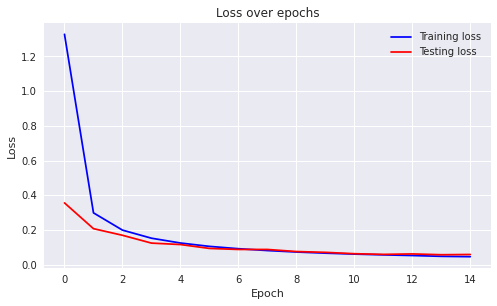

In [12]:
model, optimizer, _ = evaluation(model, criterion, optimizer, train_loader, test_loader, N_EPOCHS, DEVICE)

Here I used SGD optimizer and set my learning rate as 0.01. Now in the above plot I can see that the testing loss as well as the training loss decreases after evey epoch. I think the performance may be characterized as being fairly satisfactory overall. The 11th epoch produced the best outcomes (on the testing set).

In [50]:
ROW_IMG = 10
N_ROWS = 5

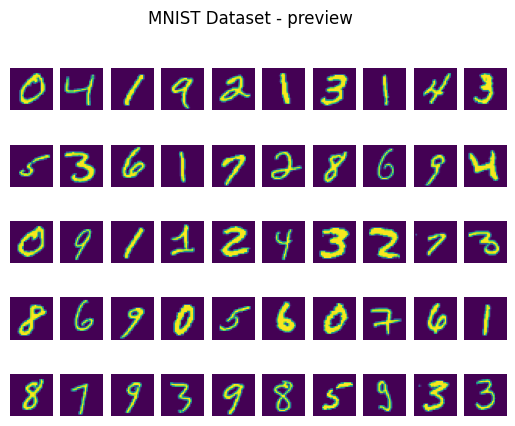

In [51]:
fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(train_dataset.data[index])
fig.suptitle('MNIST Dataset - preview');

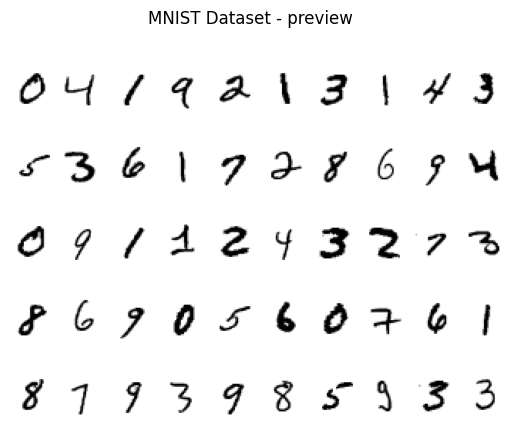

In [52]:
fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(train_dataset.data[index], cmap='gray_r')
fig.suptitle('MNIST Dataset - preview');

The following code presents a series of integers from the testing set together with the predicted label and the probability that the network assigns to that label, allowing us to assess the predictions of our model (in other words, how confident the network is in the prediction).

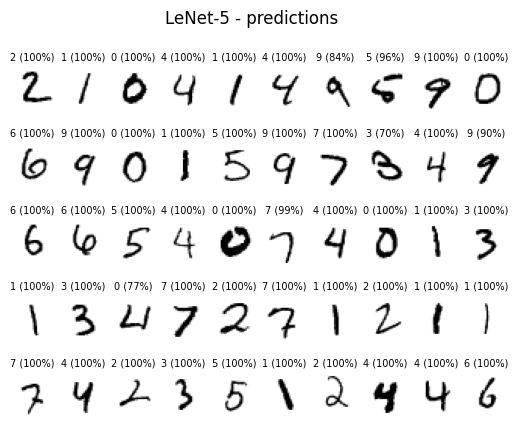

In [53]:
fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(test_dataset.data[index], cmap='gray_r')
    
    with torch.no_grad():
        model.eval()
        _, probs = model(test_dataset[index][0].unsqueeze(0))
        
    title = f'{torch.argmax(probs)} ({torch.max(probs * 100):.0f}%)'
    
    plt.title(title, fontsize=7)
fig.suptitle('LeNet-5 - predictions');

The network is almost always certain of the label, as shown in the image above, with the number 9 (in the first row, fourth from right), where it is only 84% certain that it is a 9, the number 4 (in the second last row, third from left), where it is only 77% certain that it is a 4, being the exceptions. 

Finally, we define the LeNet-5 architecture using learning rate as 0.1 and SGD as my optimizer.

In [11]:
torch.manual_seed(RANDOM_SEED)

model = LeNet5(N_CLASSES).to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
criterion = nn.CrossEntropyLoss()

12:11:59 --- Epoch: 0	Train loss: 0.3226	Test loss: 0.0741	Train accuracy: 97.88	Test accuracy: 97.94
12:12:19 --- Epoch: 1	Train loss: 0.0711	Test loss: 0.0563	Train accuracy: 98.34	Test accuracy: 98.23
12:12:37 --- Epoch: 2	Train loss: 0.0508	Test loss: 0.0546	Train accuracy: 98.53	Test accuracy: 98.20
12:12:56 --- Epoch: 3	Train loss: 0.0383	Test loss: 0.0454	Train accuracy: 99.03	Test accuracy: 98.48
12:13:15 --- Epoch: 4	Train loss: 0.0311	Test loss: 0.0359	Train accuracy: 99.29	Test accuracy: 98.79
12:13:34 --- Epoch: 5	Train loss: 0.0264	Test loss: 0.0366	Train accuracy: 99.40	Test accuracy: 98.78
12:13:53 --- Epoch: 6	Train loss: 0.0231	Test loss: 0.0468	Train accuracy: 99.22	Test accuracy: 98.74
12:14:12 --- Epoch: 7	Train loss: 0.0200	Test loss: 0.0366	Train accuracy: 99.54	Test accuracy: 98.86
12:14:31 --- Epoch: 8	Train loss: 0.0173	Test loss: 0.0394	Train accuracy: 99.44	Test accuracy: 98.65
12:14:50 --- Epoch: 9	Train loss: 0.0141	Test loss: 0.0412	Train accuracy: 99.58	T

/var/folders/mv/39f6vvvn1kb8pjc2zbvyxr5w0000gn/T/ipykernel_11139/308483355.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


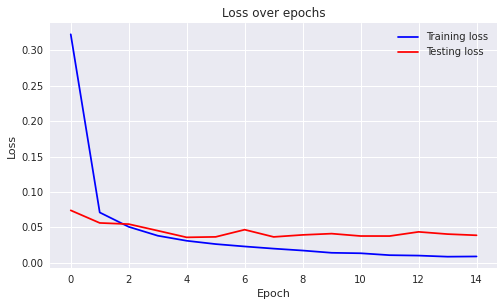

In [12]:
model, optimizer, _ = evaluation(model, criterion, optimizer, train_loader, test_loader, N_EPOCHS, DEVICE)

Here I have used 0.1 as my learning rate and SGD as my optimizer and now in the above plot I can see that the testing loss shows tiny bumps while the training loss decreases after evey epoch. I think the performance may be characterized as being fairly satisfactory overall. Here again, the 10th epoch produces the best outcomes (on the testing set).

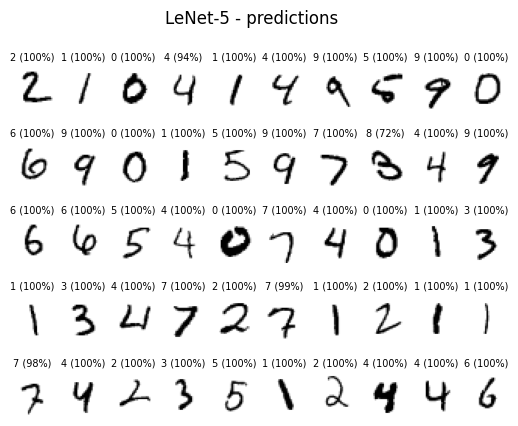

In [14]:
ROW_IMG = 10
N_ROWS = 5
fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(test_dataset.data[index], cmap='gray_r')
    
    with torch.no_grad():
        model.eval()
        _, probs = model(test_dataset[index][0].unsqueeze(0))
        
    title = f'{torch.argmax(probs)} ({torch.max(probs * 100):.0f}%)'
    
    plt.title(title, fontsize=7)
fig.suptitle('LeNet-5 - predictions');

The network is almost always certain of the label, as shown in the image above, with the number 3 (in the second row, third from right), where it is only 72% certain that it is a 3, being the only exception.

Finally, we define the LeNet-5 architecture using learning rate as 0.01 and RMSprop as my optimizer.

In [11]:
torch.manual_seed(RANDOM_SEED)

model = LeNet5(N_CLASSES).to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

12:24:13 --- Epoch: 0	Train loss: 2.3020	Test loss: 2.2988	Train accuracy: 9.07	Test accuracy: 8.96
12:24:32 --- Epoch: 1	Train loss: 2.2951	Test loss: 2.2897	Train accuracy: 35.26	Test accuracy: 36.32
12:24:51 --- Epoch: 2	Train loss: 2.2806	Test loss: 2.2651	Train accuracy: 41.76	Test accuracy: 43.06
12:25:11 --- Epoch: 3	Train loss: 2.2146	Test loss: 2.0973	Train accuracy: 47.33	Test accuracy: 48.55
12:25:30 --- Epoch: 4	Train loss: 1.5314	Test loss: 0.8069	Train accuracy: 77.31	Test accuracy: 78.23
12:25:49 --- Epoch: 5	Train loss: 0.6284	Test loss: 0.5046	Train accuracy: 84.07	Test accuracy: 84.74
12:26:10 --- Epoch: 6	Train loss: 0.4817	Test loss: 0.4285	Train accuracy: 86.77	Test accuracy: 87.25
12:26:29 --- Epoch: 7	Train loss: 0.4256	Test loss: 0.3834	Train accuracy: 88.27	Test accuracy: 88.76
12:26:49 --- Epoch: 8	Train loss: 0.3875	Test loss: 0.3529	Train accuracy: 88.99	Test accuracy: 89.51
12:27:08 --- Epoch: 9	Train loss: 0.3578	Test loss: 0.3347	Train accuracy: 89.59	Tes

/var/folders/mv/39f6vvvn1kb8pjc2zbvyxr5w0000gn/T/ipykernel_11285/308483355.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


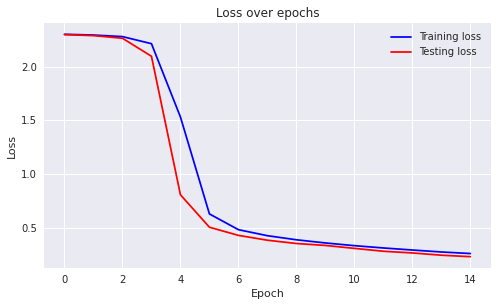

In [12]:
model, optimizer, _ = evaluation(model, criterion, optimizer, train_loader, test_loader, N_EPOCHS, DEVICE)

Here I have used 0.001 as my learning rate and SGD as my optimizer and now in the above plot I can see that both the testing and training loss shows a huge drop in loss after the 3rd epoch and thereafter decreases gradually. However, the accuracy just reached 93% in 15 epochs, therefore, in the next step I'll increase the number of epochs.

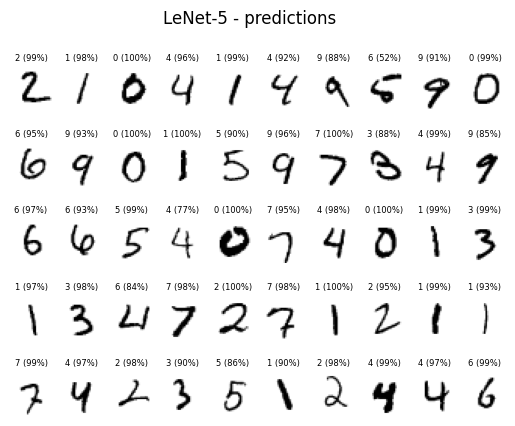

In [13]:
ROW_IMG = 10
N_ROWS = 5
fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(test_dataset.data[index], cmap='gray_r')
    
    with torch.no_grad():
        model.eval()
        _, probs = model(test_dataset[index][0].unsqueeze(0))
        
    title = f'{torch.argmax(probs)} ({torch.max(probs * 100):.0f}%)'
    
    plt.title(title, fontsize=6)
fig.suptitle('LeNet-5 - predictions');

The network is almost always certain of the label, as shown in the image above, with the number 5 (in the first row, third from right), where it is only 52% certain that it is a 5, the number 4 (in the third row, fourth from left), where it is only 77% certain that it is a 4, being the exceptions.

12:33:04 --- Epoch: 0	Train loss: 2.3020	Test loss: 2.2988	Train accuracy: 9.07	Test accuracy: 8.96
12:33:23 --- Epoch: 1	Train loss: 2.2951	Test loss: 2.2897	Train accuracy: 35.26	Test accuracy: 36.32
12:33:43 --- Epoch: 2	Train loss: 2.2806	Test loss: 2.2651	Train accuracy: 41.76	Test accuracy: 43.06
12:34:04 --- Epoch: 3	Train loss: 2.2146	Test loss: 2.0973	Train accuracy: 47.33	Test accuracy: 48.55
12:34:23 --- Epoch: 4	Train loss: 1.5314	Test loss: 0.8069	Train accuracy: 77.31	Test accuracy: 78.23
12:34:43 --- Epoch: 5	Train loss: 0.6284	Test loss: 0.5046	Train accuracy: 84.07	Test accuracy: 84.74
12:35:03 --- Epoch: 6	Train loss: 0.4817	Test loss: 0.4285	Train accuracy: 86.77	Test accuracy: 87.25
12:35:23 --- Epoch: 7	Train loss: 0.4256	Test loss: 0.3834	Train accuracy: 88.27	Test accuracy: 88.76
12:35:43 --- Epoch: 8	Train loss: 0.3875	Test loss: 0.3529	Train accuracy: 88.99	Test accuracy: 89.51
12:36:02 --- Epoch: 9	Train loss: 0.3578	Test loss: 0.3347	Train accuracy: 89.59	Tes

/var/folders/mv/39f6vvvn1kb8pjc2zbvyxr5w0000gn/T/ipykernel_11326/308483355.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


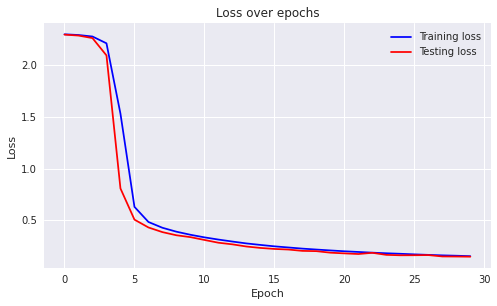

In [11]:
torch.manual_seed(RANDOM_SEED)

model = LeNet5(N_CLASSES).to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
model, optimizer, _ = evaluation(model, criterion, optimizer, train_loader, test_loader, 30, DEVICE)

After increasing the number of epochs I see that the accuracy increased to almost 96% and also we see a gradual decrease in the loss from both the datasets.

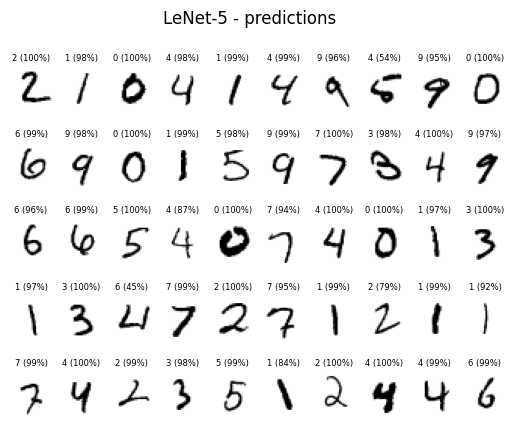

In [12]:
ROW_IMG = 10
N_ROWS = 5
fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(test_dataset.data[index], cmap='gray_r')
    
    with torch.no_grad():
        model.eval()
        _, probs = model(test_dataset[index][0].unsqueeze(0))
        
    title = f'{torch.argmax(probs)} ({torch.max(probs * 100):.0f}%)'
    
    plt.title(title, fontsize=6)
fig.suptitle('LeNet-5 - predictions');

The network is almost always certain of the label, as shown in the image above, with the number 5 (in the first row, third from right), where it is only 54% certain that it is a 5, the number 2 (in the second last row, third from right), where it is only 79% certain that it is a 2 and the number 4 in the same row(third from left) where it is 45% sure that it is a 4, being the exceptions.